<a href="https://colab.research.google.com/github/cyp328/Projects/blob/main/Lego_Set_Rating_Predictor_(2018_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import kagglehub

sb.set

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score # Added cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score


In [ ]:


# Download latest version
path = kagglehub.dataset_download("alessiasimone/lego-sets-and-price-1955-2023")

print("Path to dataset files:", path)

100%|██████████| 29.8M/29.8M [00:00<00:00, 57.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiasimone/lego-sets-and-price-1955-2023/versions/1


In [ ]:
df = pd.read_csv(os.path.join(path, 'Output.csv'), sep=';')
df.head()

/tmp/ipython-input-4276965306.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, 'Output.csv'), sep=';')


,year,Theme name,Sets Name,Sets URL,Part category,Part name,Part material,Part color,RGB,Is Transparent?,Part URL,Set Price,Number of reviews,Star rating
0,2016,Skylines,London,https://cdn.rebrickable.com/media/sets/21034-1...,Plates,Plate 4 x 8,Plastic,Dark Blue,0A3463,False,https://cdn.rebrickable.com/media/parts/elemen...,"53,3556",23,"4,7"
1,2016,Skylines,London,https://cdn.rebrickable.com/media/sets/21034-1...,Plates,Plate 4 x 8,Plastic,Trans-Dark Blue,0020A0,True,https://cdn.rebrickable.com/media/parts/elemen...,"53,3556",23,"4,7"
2,2016,Skylines,London,https://cdn.rebrickable.com/media/sets/21034-1...,Plates,Plate 4 x 8,Plastic,Dark Blue,0A3463,False,https://cdn.rebrickable.com/media/parts/elemen...,"53,3556",23,"4,7"
3,2016,Skylines,London,https://cdn.rebrickable.com/media/sets/21034-1...,Plates,Plate 4 x 8,Plastic,Bright Green,4B9F4A,False,https://cdn.rebrickable.com/media/parts/elemen...,"53,3556",23,"4,7"
4,2016,Skylines,London,https://cdn.rebrickable.com/media/sets/21034-1...,Plates,Plate 4 x 8,Plastic,Bright Light Blue,9FC3E9,False,https://cdn.rebrickable.com/media/parts/elemen...,"53,3556",23,"4,7"



# **Data Cleaning**


In [ ]:
df.info() # check data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698983 entries, 0 to 4698982
Data columns (total 14 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   year               int64 
 1   Theme name         object
 2   Sets Name          object
 3   Sets URL           object
 4   Part category      object
 5   Part name          object
 6   Part material      object
 7   Part color         object
 8   RGB                object
 9   Is Transparent?    object
 10  Part URL           object
 11  Set Price          object
 12  Number of reviews  object
 13  Star rating        object
dtypes: int64(1), object(13)
memory usage: 501.9+ MB


In [ ]:
# Drop specific columns
df = df.drop(columns=['Sets URL', 'Part URL', 'RGB'])

In [ ]:
# Convert datatypes
df['year'] = df['year'].astype(int)
df['Set Price'] = df['Set Price'].replace(',', '', regex=True).astype(float)
df['Number of reviews'] = df['Number of reviews'].replace(',','',regex=True).astype(int)
df['Star rating'] = df['Star rating'].replace(',','.',regex=True).astype(float)
df.head()

,year,Theme name,Sets Name,Part category,Part name,Part material,Part color,Is Transparent?,Set Price,Number of reviews,Star rating
0,2016,Skylines,London,Plates,Plate 4 x 8,Plastic,Dark Blue,False,533556.0,23,4.7
1,2016,Skylines,London,Plates,Plate 4 x 8,Plastic,Trans-Dark Blue,True,533556.0,23,4.7
2,2016,Skylines,London,Plates,Plate 4 x 8,Plastic,Dark Blue,False,533556.0,23,4.7
3,2016,Skylines,London,Plates,Plate 4 x 8,Plastic,Bright Green,False,533556.0,23,4.7
4,2016,Skylines,London,Plates,Plate 4 x 8,Plastic,Bright Light Blue,False,533556.0,23,4.7


In [ ]:
#Filter for years 2000 to 2023
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)
df = df[(df['year'] >= 2018) & (df['year'] <= 2023)]

In [ ]:
#Find the unique string inputs of the names before they turn into numerical numbers
df['Theme name'].unique()
df['Part category'].unique()
df['Part material'].unique()
df['Part color'].unique()


array(['Black', 'Lavender', 'Dark Turquoise', 'Light Aqua', 'Dark Azure',
       'Yellow', 'Bright Light Yellow', 'White', 'Bright Light Orange',
       'Dark Blue', 'Dark Pink', 'Medium Blue', 'Medium Azure',
       'Dark Red', 'Dark Green', 'Dark Bluish Gray', 'Light Bluish Gray',
       'Reddish Brown', 'Medium Lavender', 'Bright Pink', 'Magenta',
       'Orange', 'Tan', 'Red', 'Medium Orange', 'Sand Green',
       'Light Gray', 'Blue', 'Trans-Orange', 'Pink', 'Dark Tan',
       'Dark Brown', 'Trans-Medium Blue', 'Medium Nougat',
       'Trans-Neon Green', 'Light Violet', 'Trans-Light Blue',
       'Yellowish Green', 'Sand Red', 'Bright Green', 'Green', 'Lime',
       'Dark Orange', 'Light Orange', 'Vibrant Yellow', 'Coral',
       'Pearl Gold', 'Warm Yellowish Orange', 'Trans-Brown', 'Nougat',
       'Light Yellow', 'Dark Purple', 'Trans-Bright Green',
       'Trans-Yellow', 'Trans-Dark Blue', 'Aqua', 'Sand Blue',
       'Olive Green', 'Pastel Blue', 'Royal Blue', 'Light Purple',
 

In [ ]:
encoder_theme = LabelEncoder()
df['Theme name'] = encoder_theme.fit_transform(df['Theme name'])

encoder_color = LabelEncoder()
df['Part color'] = encoder_color.fit_transform(df['Part color'])

encoder_category = LabelEncoder()
df['Part category'] = encoder_category.fit_transform(df['Part category'])

encoder_material = LabelEncoder()
df['Part material'] = encoder_material.fit_transform(df['Part material'])

encoder_part_name = LabelEncoder()
df['Part name'] = encoder_part_name.fit_transform(df['Part name'])

encoder_sets_name = LabelEncoder()
df['Sets Name'] = encoder_sets_name.fit_transform(df['Sets Name'])
df.head()

,year,Theme name,Sets Name,Part category,Part name,Part material,Part color,Is Transparent?,Set Price,Number of reviews,Star rating
558,2018,39,130,3,285,3,1,False,4.958417e+10,4,4.8
559,2018,39,130,3,285,3,1,False,4.958417e+10,4,4.8
560,2018,39,130,3,285,3,45,False,4.958417e+10,4,4.8
561,2018,39,130,3,285,3,29,False,4.958417e+10,4,4.8
562,2018,39,130,3,285,3,46,False,4.958417e+10,4,4.8


In [ ]:
#show the name of category that is tied to the new numeric label
#Refer to this for the predictive model at the end
theme_map = pd.DataFrame({
    'Original Theme Name': encoder_theme.classes_,
    'Encoded Value': encoder_theme.transform(encoder_theme.classes_)
})

category_map = pd.DataFrame({
    'Original Part Category': encoder_category.classes_,
    'Encoded Value': encoder_category.transform(encoder_category.classes_)
})

material_map = pd.DataFrame({
    'Original Part Material': encoder_material.classes_,
    'Encoded Value': encoder_material.transform(encoder_material.classes_)
})

color_map = pd.DataFrame({
    'Original Part Color': encoder_color.classes_,
    'Encoded Value': encoder_color.transform(encoder_color.classes_)
})

# --- Display all mapping tables ---
print("Theme Name Encoding Map:")
display(theme_map)

print("Part Category Encoding Map:")
display(category_map)

print("Part Material Encoding Map:")
display(material_map)

print("Part Color Encoding Map:")
display(color_map)

Theme Name Encoding Map:


,Original Theme Name,Encoded Value
0,Airport,0
1,Architecture,1
2,Avengers,2
3,Basic Set,3
4,Brick Sketches,4
5,Brickheadz,5
6,Bricktober,6
7,City,7
8,Classic,8
9,Construction,9


Part Category Encoding Map:


,Original Part Category,Encoded Value
0,"Bars, Ladders and Fences",0
1,Baseplates,1
2,Bricks,2
3,Bricks Curved,3
4,Bricks Round and Cones,4
5,Bricks Sloped,5
6,Bricks Special,6
7,Bricks Wedged,7
8,Containers,8
9,"Duplo, Quatro and Primo",9


Part Material Encoding Map:


,Original Part Material,Encoded Value
0,Cloth,0
1,Flexible Plastic,1
2,Metal,2
3,Plastic,3
4,Rubber,4
5,NaN,5


Part Color Encoding Map:


,Original Part Color,Encoded Value
0,Aqua,0
1,Black,1
2,Blue,2
3,Bright Green,3
4,Bright Light Blue,4
...,...,...
139,Yellow,139
140,Yellowish Green,140
141,[No Color/Any Color],141
142,[Unknown],142


In [ ]:
#Creating new features that might be important factors affecting ratings
df['price_per_review'] = df['Set Price'] / (df['Number of reviews'] + 1)

# Drop any old 'theme_avg_rating_x', 'theme_avg_rating_y', or existing 'theme_avg_rating' columns if they exist
# This ensures a clean slate before re-creating the 'theme_avg_rating' column
if 'theme_avg_rating_x' in df.columns:
    df = df.drop(columns=['theme_avg_rating_x'])
if 'theme_avg_rating_y' in df.columns:
    df = df.drop(columns=['theme_avg_rating_y'])
if 'theme_avg_rating' in df.columns:
    df = df.drop(columns=['theme_avg_rating'])

theme_avg = df.groupby('Theme name')['Star rating'].mean().reset_index()
theme_avg.rename(columns={'Star rating': 'theme_avg_rating'}, inplace=True)

# Use map to directly update/create 'theme_avg_rating' based on 'Theme name'
df['theme_avg_rating'] = df['Theme name'].map(theme_avg.set_index('Theme name')['theme_avg_rating'])

#Fill in mean value for missing ratings
df['theme_avg_rating'] = df['theme_avg_rating'].fillna(df['Star rating'].mean())
df.head()

,year,Theme name,Sets Name,Part category,Part name,Part material,Part color,Is Transparent?,Set Price,Number of reviews,Star rating,price_per_review,theme_avg_rating
558,2018,39,130,3,285,3,1,False,4.958417e+10,4,4.8,9.916834e+09,4.874821
559,2018,39,130,3,285,3,1,False,4.958417e+10,4,4.8,9.916834e+09,4.874821
560,2018,39,130,3,285,3,45,False,4.958417e+10,4,4.8,9.916834e+09,4.874821
561,2018,39,130,3,285,3,29,False,4.958417e+10,4,4.8,9.916834e+09,4.874821
562,2018,39,130,3,285,3,46,False,4.958417e+10,4,4.8,9.916834e+09,4.874821


In [ ]:
print(f"Number of rows in the dataset after trimming: {df.shape[0]}")

Number of rows in the dataset after trimming: 1306933


# **Hyperparameter Tunning**

In [ ]:
# Select features (X) and target (y)
X = df[['year', 'Set Price', 'Number of reviews', 'Theme name',
    'Part category', 'Part material', 'Part color',
    'price_per_review', 'theme_avg_rating']]
y = df['Star rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Take a 10% sample of the training data for faster hyperparameter tuning
sample_fraction = 0.1 # You can adjust this fraction

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=sample_fraction, random_state=42 # Removed stratify=y_train
)


# Define Base Model

xgb_model = XGBRegressor(objective='reg:squarederror',
    n_jobs=-1,
    tree_method='hist',   # faster training for large datasets
    random_state=42)


# Define Hyperparameter Grid

param_dist = {'n_estimators': [200, 400, 600],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.2, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 3]}


In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Running lightweight hyperparameter tuning on sampled data...")
random_search.fit(X_train_sample, y_train_sample)

print("\n Best Parameters Found:")
print(random_search.best_params_)

# ------------------------------
# Evaluate Tuned Model
# ------------------------------
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Model Evaluation Results (on full X_test):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Running lightweight hyperparameter tuning on sampled data...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

 Best Parameters Found:
{'subsample': np.float64(1.0), 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': np.float64(0.0575), 'gamma': 0, 'colsample_bytree': np.float64(0.8)}

 Model Evaluation Results (on full X_test):
Mean Absolute Error (MAE): 0.0045
R² Score: 0.9885


In [ ]:
# Cross Validation on Best Model using K-Fold

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)

print("\n 5-Fold Cross Validation Results:")
print("R² scores for each fold:", np.round(cv_scores, 3))
print("Average R²:", np.mean(cv_scores).round(3))


 5-Fold Cross Validation Results:
R² scores for each fold: [0.973 0.978 0.993 0.993 0.981]
Average R²: 0.984


# **Feature Importance**

<Figure size 1000x600 with 0 Axes>

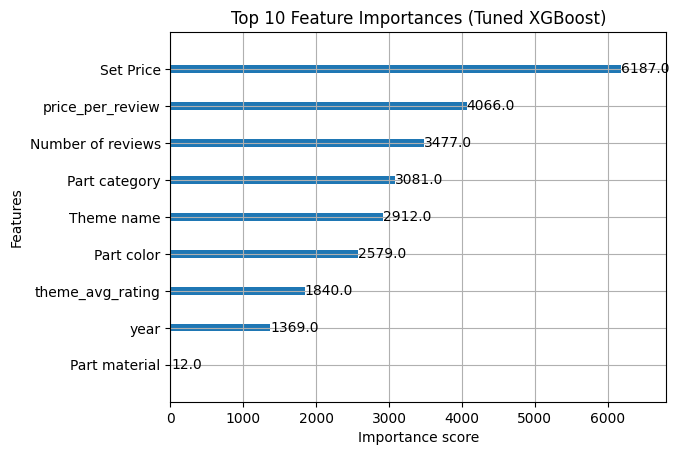

In [ ]:
# Feature Importance Graph
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances (Tuned XGBoost)")
plt.show()

# **Machine Learning via XGBoost**

In [ ]:
# 1. Best parameters from tuning
best_params = random_search.best_params_

# 2. Create NEW model with tuned params
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    **best_params
)

# 3. Train model
best_xgb_model.fit(X_train, y_train)

# 4. Evaluate
y_pred = best_xgb_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))

MAE: 0.003845758287464388
R² : 0.9891585889675846


# **Creating Prediction Model**

In [ ]:
def predict_rating(year, price, reviews, theme_name, part_category, part_material, part_color):
    # Create a dataframe with 1 row (your input)
    new_data = pd.DataFrame([{
        'year': year,
        'Set Price': price,
        'Number of reviews': reviews,
        'Theme name': theme_name,
        'Part category': part_category,
        'Part material': part_material,
        'Part color': part_color
    }])

    # Engineer features the same way as training data
    new_data['price_per_review'] = new_data['Set Price'] / (new_data['Number of reviews'] + 1)

    # Apply label encoding for categorical fields *before* any merge or prediction
    # Ensure the encoders are correctly fitted from the global scope
    new_data['Theme name'] = encoder_theme.transform(new_data['Theme name'])
    new_data['Part category'] = encoder_category.transform(new_data['Part category'])
    new_data['Part material'] = encoder_material.transform(new_data['Part material'])
    new_data['Part color'] = encoder_color.transform(new_data['Part color'])

    # theme_avg_rating must match training logic
    # Now 'Theme name' in new_data is already encoded as int64, matching theme_avg
    new_data = new_data.merge(theme_avg, on='Theme name', how='left')

    # Predict using your trained model
    prediction = best_xgb_model.predict(new_data)[0]

    return prediction

In [ ]:
pred = predict_rating(
    year=2020,
    price=149.99,
    reviews=345,
    theme_name="Airport",
    part_category="Bars, Ladders and Fences",
    part_material="Cloth",
    part_color="Aqua"
)

print("Predicted Star Rating:", pred)

Predicted Star Rating: 4.4300723
